In [1]:
! pip install numpy scipy matplotlib xarray pandas netcdf4 tqdm tensorflow scikit-learn seaborn

     |████████████████████████████████| 4.1MB 6.4MB/s 
     |████████████████████████████████| 327kB 41.6MB/s 


In [2]:
pip install --upgrade pandas

Requirement already up-to-date: pandas in /usr/local/lib/python3.6/dist-packages (1.0.5)


In [3]:
import s3fs
import seaborn as sns
import pandas as pd
import pyarrow
import re
import random
import pandas as pd
import numpy as np
from tqdm import trange
import matplotlib.pyplot as plt
from glob import glob
from os.path import join, exists
from matplotlib.colors import LogNorm
import tensorflow as tf
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow.keras.layers import Dense, Input, LSTM
from tensorflow.keras.models import Model, Sequential
from sklearn.model_selection import GroupKFold
from tensorflow.keras.optimizers import Adam

%matplotlib inline

seed = 8886
np.random.seed(seed)
random.seed(seed)
tf.random.set_seed(seed)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
def fetch_data(f):
    """ Load data directly from Amazon S3 storage """
    
    obj = fs.open(f)
    df = pd.read_parquet(obj)
    return df

### **LSTM**

In [5]:
## =====load data=====
fs = s3fs.S3FileSystem(anon=True)
gecko_files = fs.ls("ncar-aiml-data-commons/gecko/")[1:]
test, train, val = map(fetch_data, gecko_files)

In [6]:
## =====Scale the data=====
# Initialize the scaler
input_scaler = StandardScaler();
output_scaler = StandardScaler();
# Scale the dataset
scaled_train_in = input_scaler.fit_transform(train.iloc[:,1:-1])
scaled_train_out = output_scaler.fit_transform(train.iloc[:,[1,2,3]])
scaled_val_in = input_scaler.transform(val.iloc[:,1:-1])
scaled_val_out = output_scaler.transform(val.iloc[:,[1,2,3]])

In [7]:
## =====Arrange the data to be 3-D input for LSTM=====
# Define some parameters
n_timestep = int(10); # could dyamically change this parameter
n_time = int(60*24);
n_sim_train = int(np.shape(scaled_train_in)[0]/n_time);
n_sim_valid = int(np.shape(scaled_val_in)[0]/n_time);
# Initialize the matrix
Train_3D_in = np.zeros((n_sim_train*(n_time-n_timestep),n_timestep,9))
Train_3D_out = np.zeros((n_sim_train*(n_time-n_timestep),3))
Valid_3D_in = np.zeros((n_sim_valid*(n_time-n_timestep),n_timestep,9))
Valid_3D_out = np.zeros((n_sim_valid*(n_time-n_timestep),3))
# Training
for j in range(n_sim_train):
  for i in range(n_time-n_timestep):
    Train_3D_in[i+(n_time-n_timestep)*j,:,:] = scaled_train_in[i+(n_time*j):i+n_timestep+(n_time*j),:];
    Train_3D_out[i+(n_time-n_timestep)*j,:] = scaled_train_out[i+n_timestep+(n_time*j),:];
# Validation
for j in range(n_sim_valid):
  for i in range(n_time-n_timestep):
    Valid_3D_in[i+(n_time-n_timestep)*j,:,:] = scaled_val_in[i+(n_time*j):i+n_timestep+(n_time*j),:];
    Valid_3D_out[i+(n_time-n_timestep)*j,:] = scaled_val_out[i+n_timestep+(n_time*j),:];
#
print(Train_3D_in.shape,Train_3D_out.shape,Valid_3D_in.shape,Valid_3D_out.shape)

(2002000, 10, 9) (2002000, 3) (286000, 10, 9) (286000, 3)


In [ ]:
### =====Train the LSTM=====
#
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM
# Design network
model = Sequential()
model.add(LSTM(64,activation='relu',input_shape=(Train_3D_in.shape[1], Train_3D_in.shape[2]),return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(3))
model.compile(loss='mse', optimizer='adam', metrics=['mae'])
# Fit network
history = model.fit(Train_3D_in, Train_3D_out, epochs=5, batch_size=1024, validation_data=(Valid_3D_in,Valid_3D_out), verbose=1, shuffle=False)

Using TensorFlow backend.


Train on 2002000 samples, validate on 286000 samples
Epoch 1/5
2002000/2002000 [==============================] - 49s 24us/step - loss: 0.0538 - mae: 0.1504 - val_loss: 0.0031 - val_mae: 0.0418
Epoch 2/5
2002000/2002000 [==============================] - 47s 24us/step - loss: 0.0215 - mae: 0.0989 - val_loss: 0.0020 - val_mae: 0.0305
Epoch 3/5
2002000/2002000 [==============================] - 47s 24us/step - loss: 0.0194 - mae: 0.0910 - val_loss: 0.0031 - val_mae: 0.0388
Epoch 4/5
2002000/2002000 [==============================] - 48s 24us/step - loss: 0.0186 - mae: 0.0871 - val_loss: 0.0019 - val_mae: 0.0320
Epoch 5/5
2002000/2002000 [==============================] - 48s 24us/step - loss: 0.0180 - mae: 0.0846 - val_loss: 0.0011 - val_mae: 0.0244


In [ ]:
## =====Evaluate the LSTM=====
# make a prediction
yhat = model.predict(Valid_3D_in)
# orgnize the matrix
inv_yhat = output_scaler.inverse_transform(yhat)
# the truth
inv_org = output_scaler.inverse_transform(Valid_3D_out)

In [ ]:
## =====Build the box emulator=====
num_per_sim = 1430*5;
Prediction = np.zeros((num_per_sim,3))
for index in range(num_per_sim):
  # Preapre the input
  if index%num_per_sim == 0:
    Input_X = Valid_3D_in[index:index+1,:,:]
  else:
    Input_X = np.zeros((1,10,9))
    Input_X[0,0:9,:] = Valid_3D_in[index:index+1,0:9,:]
    Input_X[0,9,:] = input_scaler.inverse_transform(Valid_3D_in[index:index+1,9,:])
    Input_X[0,9,0:3] = Prediction[index-1,:]
    Input_X[0,9,:] = input_scaler.transform(Input_X[0,9:10,:])
  # Make prediction
  Output_Y = model.predict(Input_X)
  Prediction[index,:] = output_scaler.inverse_transform(Output_Y)

In [ ]:
import matplotlib as mpl
# set figure defaults
mpl.rcParams['figure.dpi'] = 150
plt.rcParams['figure.figsize'] = (12.0/2, 10.0/2)

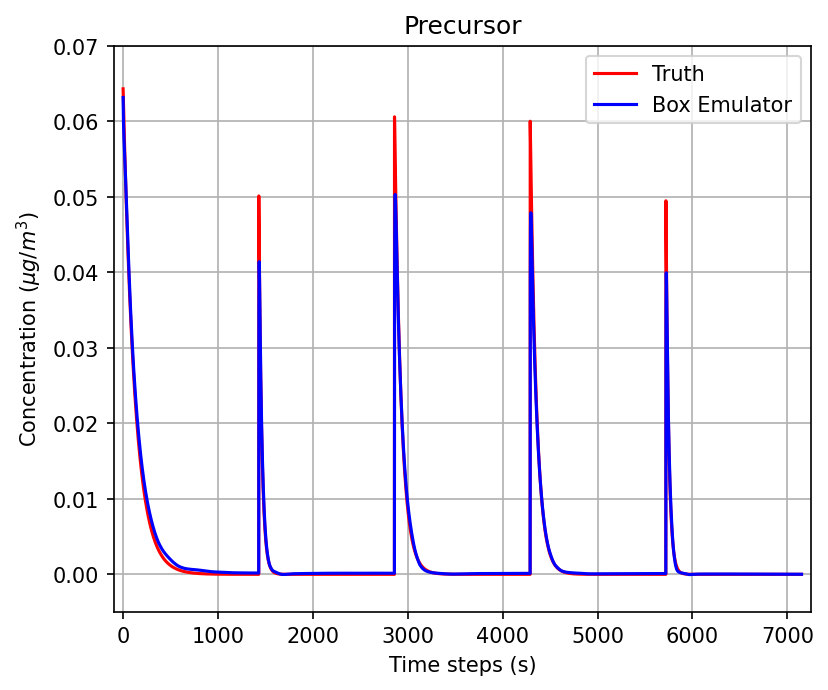

In [ ]:
plt.figure()
#
plt.plot(inv_org[0:num_per_sim,0],label='Truth',color='r')
plt.plot(Prediction[0:num_per_sim,0],label='Box Emulator',color='b')
#
plt.xlabel('Time steps (s)')
plt.ylabel('Concentration ($\mu g/m^3$)')
plt.title('Precursor')
#
plt.xlim(-100,1430*5+100)
plt.ylim(-0.005,0.07)
#
plt.legend()
plt.grid()
#
plt.savefig('Precursor.png', dpi=600,orientation='landscape', papertype=None, format='png',transparent=True, pad_inches=0.1, metadata=None,bbox_inches='tight'); 

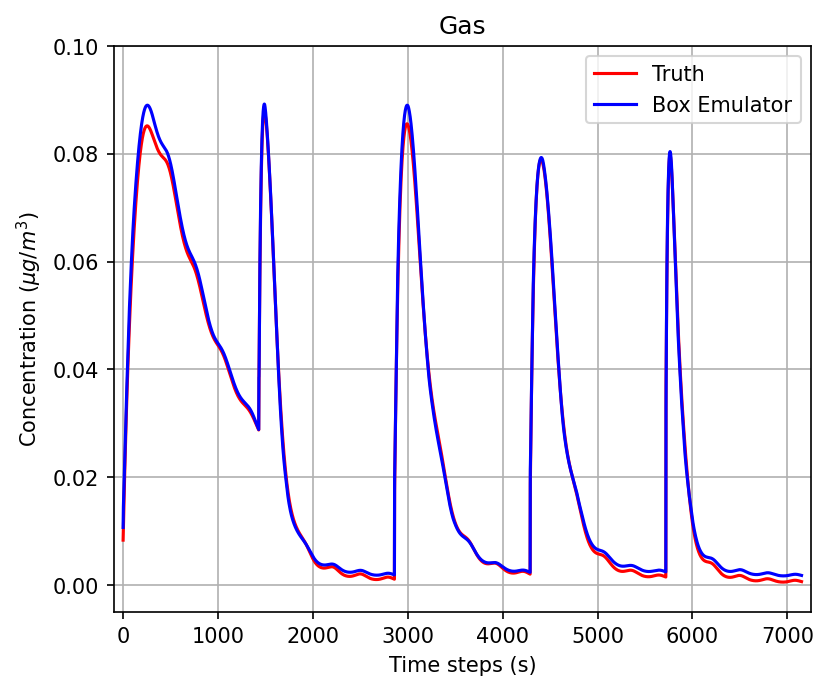

In [ ]:
plt.figure()
#
plt.plot(inv_org[0:num_per_sim,1],label='Truth',color='r')
plt.plot(Prediction[0:num_per_sim,1],label='Box Emulator',color='b')
#
plt.xlabel('Time steps (s)')
plt.ylabel('Concentration ($\mu g/m^3$)')
plt.title('Gas')
#
plt.xlim(-100,1430*5+100)
plt.ylim(-0.005,0.10)
#
plt.legend()
plt.grid()
#
plt.savefig('Gas.png', dpi=600,orientation='landscape', papertype=None, format='png',transparent=True, pad_inches=0.1, metadata=None,bbox_inches='tight'); 

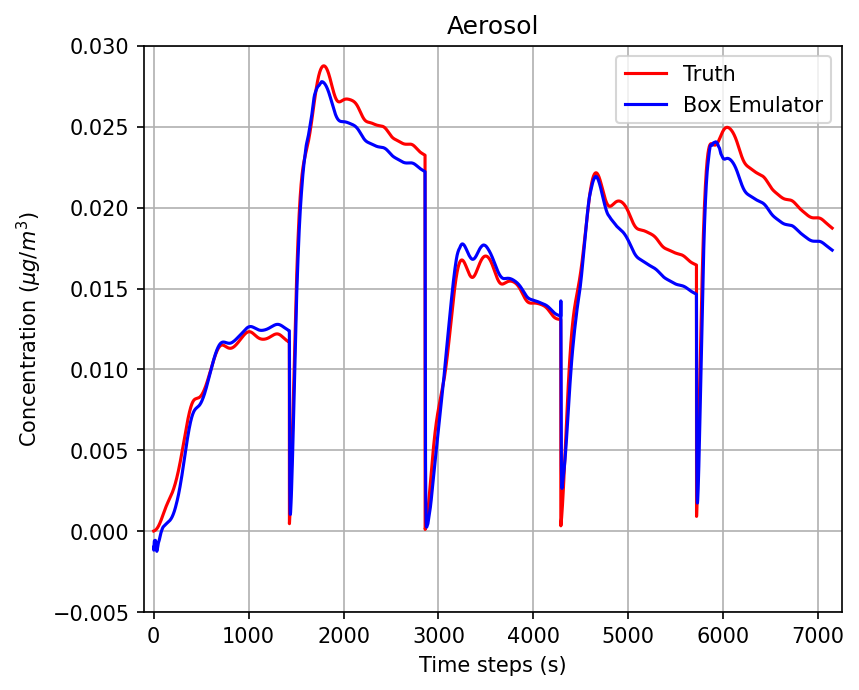

In [ ]:
plt.figure()
#
plt.plot(inv_org[0:num_per_sim,2],label='Truth',color='r')
plt.plot(Prediction[0:num_per_sim,2],label='Box Emulator',color='b')
#
plt.xlabel('Time steps (s)')
plt.ylabel('Concentration ($\mu g/m^3$)')
plt.title('Aerosol')
#
plt.xlim(-100,1430*5+100)
plt.ylim(-0.005,0.03)
#
plt.legend()
plt.grid()
#
plt.savefig('Aerosol.png', dpi=600,orientation='landscape', papertype=None, format='png',transparent=True, pad_inches=0.1, metadata=None,bbox_inches='tight'); 